# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

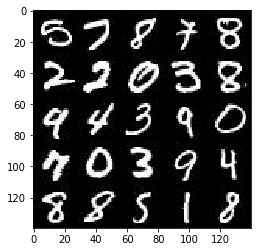

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

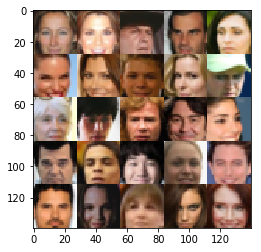

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input=tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name="real_input")
    z_input=tf.placeholder(tf.float32,(None,z_dim),name="z_input")
    learning_rate=tf.placeholder(tf.float32,(None),name="learning_rate")

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        
        hidden_layer1 = tf.layers.conv2d(images, 32, 5, 2, 'same')
        relu_layer1= tf.maximum(alpha *hidden_layer1, hidden_layer1)
        
        hidden_layer2 = tf.layers.conv2d(relu_layer1, 64, 5, 2, 'same')
        batch_layer2 = tf.layers.batch_normalization(hidden_layer2, training=True)
        relu_layer2 = tf.maximum(alpha * batch_layer2, batch_layer2)
        
        hidden_layer3 = tf.layers.conv2d(relu_layer2, 512, 5, 2, 'same')
        batch_layer3 = tf.layers.batch_normalization(hidden_layer3, training=True)
        relu_layer3 = tf.maximum(alpha * batch_layer3, batch_layer3)
        
        flat = tf.reshape(relu_layer3, (-1, 4*4*1024))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
    
        hidden_layer1 = tf.layers.dense(z, 2*2*512)
        hidden_layer1 = tf.reshape(hidden_layer1, (-1, 2, 2, 512))
        batch_layer1 = tf.layers.batch_normalization(hidden_layer1, training=is_train)
        relu_layer1 = tf.maximum(alpha * batch_layer1, batch_layer1)
    
        hidden_layer2 = tf.layers.conv2d_transpose(relu_layer1, 256, 5, 2, 'valid')
        batch_layer2 = tf.layers.batch_normalization(hidden_layer2, training=is_train)
        relu_layer2 = tf.maximum(alpha * batch_layer2, batch_layer2)
    
        hidden_layer3 = tf.layers.conv2d_transpose(relu_layer2, 128, 5, 2, 'same')
        batch_layer3 = tf.layers.batch_normalization(hidden_layer3, training=is_train)
        relu_layer3 = tf.maximum(alpha * batch_layer3, batch_layer3)
    
        logits = tf.layers.conv2d_transpose(relu_layer3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
 
        return out 

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth=0.1
    # TODO: Implement Function
    generator_model = generator(input_z, out_channel_dim)
    discriminator_real_model, discriminator_real_logits = discriminator(input_real)
    discriminator_fake_model, discriminator_fake_logits = discriminator(generator_model, reuse=True)
    
    #discriminator loss
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_real_logits, labels=tf.ones_like(discriminator_real_model)*(1-smooth)))
    #d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_real_logits, labels=tf.ones_like(discriminator_real_model)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_fake_logits, labels=tf.zeros_like(discriminator_real_model)))
    d_loss = d_loss_real + d_loss_fake
    
    #generator loss
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_fake_logits, labels=tf.ones_like(discriminator_fake_model)))

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    training_variables = tf.trainable_variables()
    discriminator_variables = [var for var in training_variables if 'discriminator' in var.name]
    generator_variables = [var for var in training_variables if 'generator' in  var.name]
     
    training_discriminator_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_variables)
    training_generator_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=generator_variables)
        
    return training_discriminator_opt, training_generator_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_width, img_height, img_channels = data_shape
    real_input, z_input, rate_learn = model_inputs(img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    discriminator_opt, generator_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    i = 0
    losses = []
      
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                i += 1
                batch_images *= 2.0
                
                #input random noise
                input_z = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                #optimitizers
                _ = sess.run(discriminator_opt, feed_dict={real_input: batch_images, z_input: input_z, rate_learn: learning_rate})
                _ = sess.run(generator_opt, feed_dict={z_input: input_z, rate_learn: learning_rate})
                
                if i % 20 == 0:
                    d_training_loss = d_loss.eval({z_input: input_z, real_input: batch_images})
                    g_training_loss = g_loss.eval({z_input: input_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),"Discriminator_Loss: {:.5f}...".format(d_training_loss),"Generator_Loss: {:.5f}".format(g_training_loss))
                    losses.append((d_training_loss, g_training_loss))
                    
                #output Every 100 batches
                if i % 100 == 0:
                    show_generator_output(sess, 25, z_input, img_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator_Loss: 0.90899... Generator_Loss: 16.59544
Epoch 1/2... Discriminator_Loss: 8.89020... Generator_Loss: 38.78229
Epoch 1/2... Discriminator_Loss: 2.74487... Generator_Loss: 0.88296
Epoch 1/2... Discriminator_Loss: 5.94578... Generator_Loss: 17.89707
Epoch 1/2... Discriminator_Loss: 1.78839... Generator_Loss: 8.79193


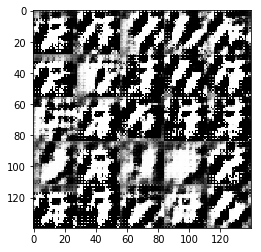

Epoch 1/2... Discriminator_Loss: 2.69528... Generator_Loss: 5.05749
Epoch 1/2... Discriminator_Loss: 1.10791... Generator_Loss: 2.15133
Epoch 1/2... Discriminator_Loss: 3.55426... Generator_Loss: 10.32819
Epoch 1/2... Discriminator_Loss: 0.59800... Generator_Loss: 4.63188
Epoch 1/2... Discriminator_Loss: 1.05806... Generator_Loss: 1.92787


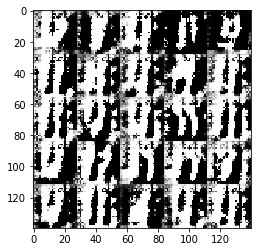

Epoch 1/2... Discriminator_Loss: 3.07717... Generator_Loss: 8.08547
Epoch 1/2... Discriminator_Loss: 0.63709... Generator_Loss: 2.36598
Epoch 1/2... Discriminator_Loss: 3.70670... Generator_Loss: 0.11426
Epoch 1/2... Discriminator_Loss: 1.57722... Generator_Loss: 4.93650
Epoch 1/2... Discriminator_Loss: 1.34621... Generator_Loss: 0.74387


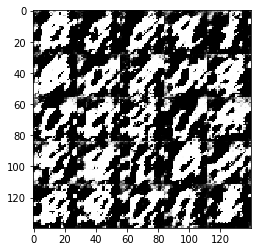

Epoch 1/2... Discriminator_Loss: 1.09050... Generator_Loss: 3.40132
Epoch 1/2... Discriminator_Loss: 1.10564... Generator_Loss: 1.14348
Epoch 1/2... Discriminator_Loss: 0.79026... Generator_Loss: 1.63587
Epoch 1/2... Discriminator_Loss: 1.02049... Generator_Loss: 1.97242
Epoch 1/2... Discriminator_Loss: 0.77698... Generator_Loss: 1.58967


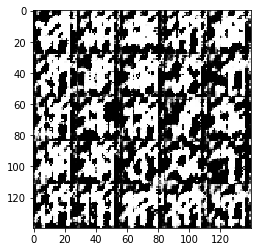

Epoch 1/2... Discriminator_Loss: 2.50973... Generator_Loss: 5.40011
Epoch 1/2... Discriminator_Loss: 1.15376... Generator_Loss: 0.94203
Epoch 1/2... Discriminator_Loss: 1.67128... Generator_Loss: 4.54076
Epoch 1/2... Discriminator_Loss: 1.55549... Generator_Loss: 0.72999
Epoch 1/2... Discriminator_Loss: 1.01228... Generator_Loss: 1.93907


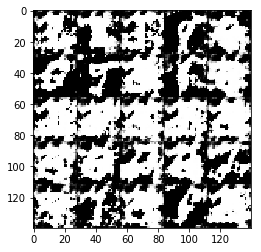

Epoch 1/2... Discriminator_Loss: 1.63480... Generator_Loss: 0.60686
Epoch 1/2... Discriminator_Loss: 1.05224... Generator_Loss: 1.80715
Epoch 1/2... Discriminator_Loss: 0.95112... Generator_Loss: 1.23891
Epoch 1/2... Discriminator_Loss: 1.15032... Generator_Loss: 1.17053
Epoch 1/2... Discriminator_Loss: 1.17954... Generator_Loss: 2.99077


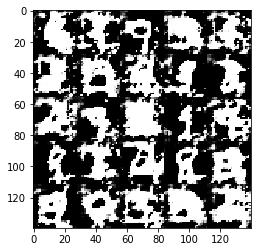

Epoch 1/2... Discriminator_Loss: 0.89551... Generator_Loss: 1.75538
Epoch 1/2... Discriminator_Loss: 1.08192... Generator_Loss: 0.98492
Epoch 1/2... Discriminator_Loss: 0.90456... Generator_Loss: 1.09313
Epoch 1/2... Discriminator_Loss: 1.22490... Generator_Loss: 0.96724
Epoch 1/2... Discriminator_Loss: 1.26386... Generator_Loss: 2.59408


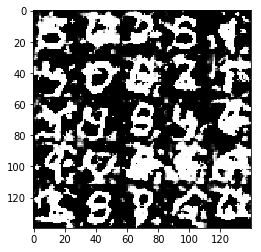

Epoch 1/2... Discriminator_Loss: 0.94476... Generator_Loss: 1.77785
Epoch 1/2... Discriminator_Loss: 1.06413... Generator_Loss: 1.48802
Epoch 1/2... Discriminator_Loss: 0.95273... Generator_Loss: 2.24190
Epoch 1/2... Discriminator_Loss: 0.96525... Generator_Loss: 1.18228
Epoch 1/2... Discriminator_Loss: 1.11214... Generator_Loss: 1.55605


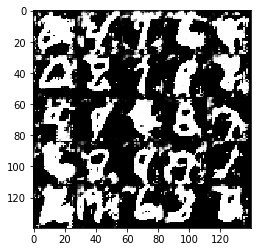

Epoch 1/2... Discriminator_Loss: 0.88508... Generator_Loss: 1.44937
Epoch 1/2... Discriminator_Loss: 1.21192... Generator_Loss: 0.88330
Epoch 1/2... Discriminator_Loss: 1.23707... Generator_Loss: 1.72560
Epoch 1/2... Discriminator_Loss: 1.62555... Generator_Loss: 2.44447
Epoch 1/2... Discriminator_Loss: 0.95361... Generator_Loss: 1.44802


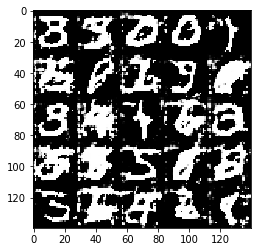

Epoch 1/2... Discriminator_Loss: 1.94599... Generator_Loss: 3.33110
Epoch 2/2... Discriminator_Loss: 0.90944... Generator_Loss: 1.02485
Epoch 2/2... Discriminator_Loss: 1.14906... Generator_Loss: 0.97352
Epoch 2/2... Discriminator_Loss: 1.14983... Generator_Loss: 1.61202
Epoch 2/2... Discriminator_Loss: 1.20958... Generator_Loss: 1.87795


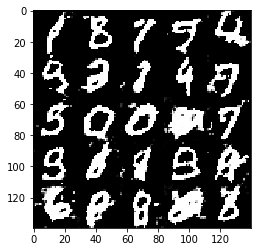

Epoch 2/2... Discriminator_Loss: 1.20946... Generator_Loss: 2.31960
Epoch 2/2... Discriminator_Loss: 0.99449... Generator_Loss: 1.24641
Epoch 2/2... Discriminator_Loss: 0.96063... Generator_Loss: 1.71742
Epoch 2/2... Discriminator_Loss: 1.17657... Generator_Loss: 0.87911
Epoch 2/2... Discriminator_Loss: 1.18373... Generator_Loss: 0.78002


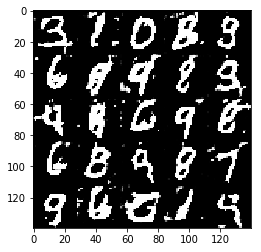

Epoch 2/2... Discriminator_Loss: 1.46838... Generator_Loss: 2.53653
Epoch 2/2... Discriminator_Loss: 0.95928... Generator_Loss: 1.13486
Epoch 2/2... Discriminator_Loss: 1.07158... Generator_Loss: 2.13644
Epoch 2/2... Discriminator_Loss: 1.22057... Generator_Loss: 0.61860
Epoch 2/2... Discriminator_Loss: 1.24674... Generator_Loss: 0.73511


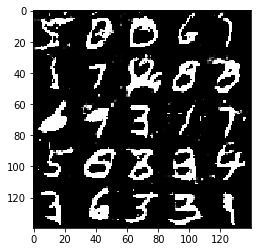

Epoch 2/2... Discriminator_Loss: 0.90421... Generator_Loss: 1.22015
Epoch 2/2... Discriminator_Loss: 1.41304... Generator_Loss: 0.52267
Epoch 2/2... Discriminator_Loss: 0.96935... Generator_Loss: 1.16692
Epoch 2/2... Discriminator_Loss: 1.99446... Generator_Loss: 0.29465
Epoch 2/2... Discriminator_Loss: 1.41611... Generator_Loss: 0.57650


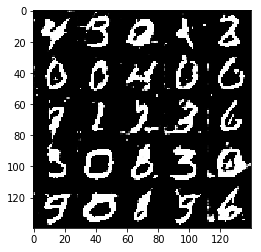

Epoch 2/2... Discriminator_Loss: 1.06085... Generator_Loss: 0.84097
Epoch 2/2... Discriminator_Loss: 1.65637... Generator_Loss: 0.39426
Epoch 2/2... Discriminator_Loss: 0.93387... Generator_Loss: 1.07782
Epoch 2/2... Discriminator_Loss: 0.91938... Generator_Loss: 1.10953
Epoch 2/2... Discriminator_Loss: 1.10717... Generator_Loss: 1.85831


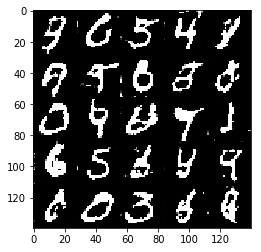

Epoch 2/2... Discriminator_Loss: 1.40244... Generator_Loss: 0.70729
Epoch 2/2... Discriminator_Loss: 1.05612... Generator_Loss: 0.84782
Epoch 2/2... Discriminator_Loss: 1.83868... Generator_Loss: 0.37658
Epoch 2/2... Discriminator_Loss: 1.18088... Generator_Loss: 0.79542
Epoch 2/2... Discriminator_Loss: 1.21535... Generator_Loss: 0.70486


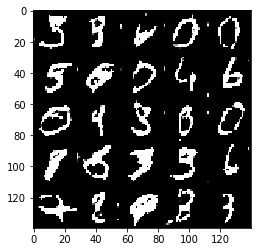

Epoch 2/2... Discriminator_Loss: 0.99464... Generator_Loss: 1.77300
Epoch 2/2... Discriminator_Loss: 2.06262... Generator_Loss: 0.34231
Epoch 2/2... Discriminator_Loss: 0.93563... Generator_Loss: 1.20391
Epoch 2/2... Discriminator_Loss: 1.19600... Generator_Loss: 2.49404
Epoch 2/2... Discriminator_Loss: 1.13361... Generator_Loss: 0.73706


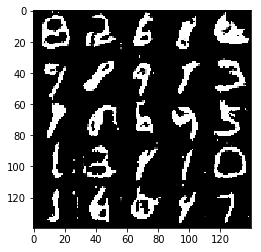

Epoch 2/2... Discriminator_Loss: 1.99906... Generator_Loss: 0.48085
Epoch 2/2... Discriminator_Loss: 1.27129... Generator_Loss: 0.65547
Epoch 2/2... Discriminator_Loss: 1.37135... Generator_Loss: 0.55215
Epoch 2/2... Discriminator_Loss: 0.87480... Generator_Loss: 1.14045
Epoch 2/2... Discriminator_Loss: 1.57948... Generator_Loss: 3.45419


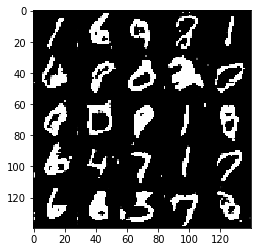

Epoch 2/2... Discriminator_Loss: 0.98130... Generator_Loss: 1.91317
Epoch 2/2... Discriminator_Loss: 1.25996... Generator_Loss: 0.73619
Epoch 2/2... Discriminator_Loss: 1.00492... Generator_Loss: 1.89625
Epoch 2/2... Discriminator_Loss: 0.80980... Generator_Loss: 1.42786
Epoch 2/2... Discriminator_Loss: 0.82798... Generator_Loss: 1.65846


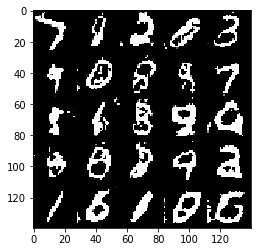

Epoch 2/2... Discriminator_Loss: 2.15345... Generator_Loss: 0.33832
Epoch 2/2... Discriminator_Loss: 0.77395... Generator_Loss: 1.39729
Epoch 2/2... Discriminator_Loss: 1.06744... Generator_Loss: 0.85455


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/5... Discriminator_Loss: 5.07536... Generator_Loss: 0.58990
Epoch 1/5... Discriminator_Loss: 1.03623... Generator_Loss: 6.25453
Epoch 1/5... Discriminator_Loss: 6.09977... Generator_Loss: 11.85247
Epoch 1/5... Discriminator_Loss: 1.83271... Generator_Loss: 7.69797
Epoch 1/5... Discriminator_Loss: 0.77988... Generator_Loss: 2.37071


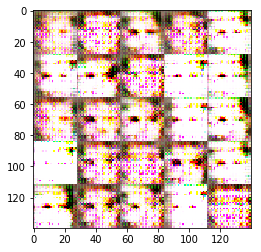

Epoch 1/5... Discriminator_Loss: 0.55429... Generator_Loss: 2.78147
Epoch 1/5... Discriminator_Loss: 0.62052... Generator_Loss: 3.53090
Epoch 1/5... Discriminator_Loss: 0.51147... Generator_Loss: 2.45723
Epoch 1/5... Discriminator_Loss: 0.57535... Generator_Loss: 2.35222
Epoch 1/5... Discriminator_Loss: 0.56952... Generator_Loss: 2.20150


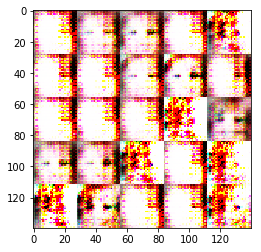

Epoch 1/5... Discriminator_Loss: 0.62708... Generator_Loss: 1.98452
Epoch 1/5... Discriminator_Loss: 0.57453... Generator_Loss: 3.43265
Epoch 1/5... Discriminator_Loss: 1.26900... Generator_Loss: 1.91337
Epoch 1/5... Discriminator_Loss: 1.00594... Generator_Loss: 1.69753
Epoch 1/5... Discriminator_Loss: 0.99227... Generator_Loss: 2.92950


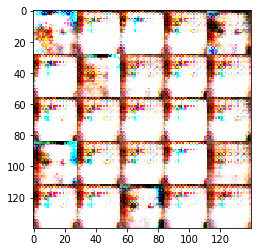

Epoch 1/5... Discriminator_Loss: 1.18290... Generator_Loss: 1.70472
Epoch 1/5... Discriminator_Loss: 2.16027... Generator_Loss: 0.97833
Epoch 1/5... Discriminator_Loss: 2.38233... Generator_Loss: 6.65054
Epoch 1/5... Discriminator_Loss: 0.95575... Generator_Loss: 1.80389
Epoch 1/5... Discriminator_Loss: 4.05391... Generator_Loss: 0.04934


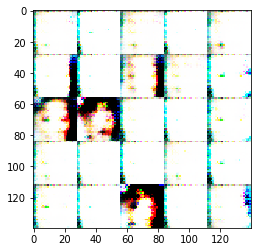

Epoch 1/5... Discriminator_Loss: 1.13831... Generator_Loss: 1.26086
Epoch 1/5... Discriminator_Loss: 1.78547... Generator_Loss: 0.42155
Epoch 1/5... Discriminator_Loss: 0.88218... Generator_Loss: 1.28746
Epoch 1/5... Discriminator_Loss: 1.17155... Generator_Loss: 1.52033
Epoch 1/5... Discriminator_Loss: 1.51668... Generator_Loss: 3.00484


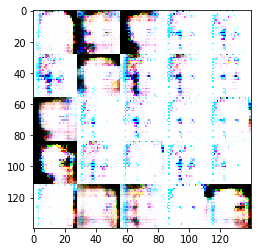

Epoch 1/5... Discriminator_Loss: 0.97425... Generator_Loss: 2.40800
Epoch 1/5... Discriminator_Loss: 1.51566... Generator_Loss: 2.30455
Epoch 1/5... Discriminator_Loss: 0.94842... Generator_Loss: 1.41190
Epoch 1/5... Discriminator_Loss: 1.13279... Generator_Loss: 1.01702
Epoch 1/5... Discriminator_Loss: 1.29968... Generator_Loss: 0.78286


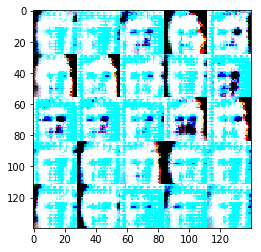

Epoch 1/5... Discriminator_Loss: 1.12381... Generator_Loss: 1.11107
Epoch 1/5... Discriminator_Loss: 0.85112... Generator_Loss: 1.31658
Epoch 1/5... Discriminator_Loss: 1.41622... Generator_Loss: 0.76975
Epoch 1/5... Discriminator_Loss: 1.06784... Generator_Loss: 1.48005
Epoch 1/5... Discriminator_Loss: 1.97283... Generator_Loss: 0.94717


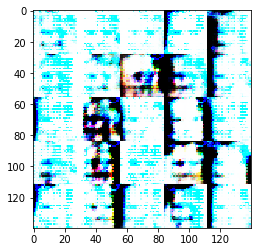

Epoch 1/5... Discriminator_Loss: 1.49094... Generator_Loss: 0.58327
Epoch 1/5... Discriminator_Loss: 1.38902... Generator_Loss: 0.71900
Epoch 1/5... Discriminator_Loss: 1.12342... Generator_Loss: 2.14187
Epoch 1/5... Discriminator_Loss: 1.46821... Generator_Loss: 0.50003
Epoch 1/5... Discriminator_Loss: 0.84717... Generator_Loss: 1.31919


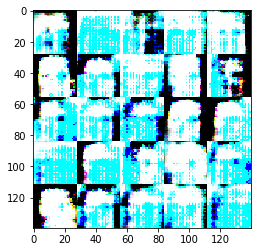

Epoch 1/5... Discriminator_Loss: 1.03725... Generator_Loss: 1.30287
Epoch 1/5... Discriminator_Loss: 3.36208... Generator_Loss: 4.54862
Epoch 1/5... Discriminator_Loss: 1.07020... Generator_Loss: 1.01419
Epoch 1/5... Discriminator_Loss: 0.88623... Generator_Loss: 1.36649
Epoch 1/5... Discriminator_Loss: 1.02309... Generator_Loss: 0.94389


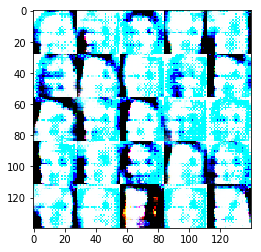

Epoch 1/5... Discriminator_Loss: 0.78842... Generator_Loss: 1.87383
Epoch 1/5... Discriminator_Loss: 1.02529... Generator_Loss: 0.94989
Epoch 1/5... Discriminator_Loss: 0.70273... Generator_Loss: 1.72037
Epoch 1/5... Discriminator_Loss: 1.21647... Generator_Loss: 1.28258
Epoch 1/5... Discriminator_Loss: 1.10510... Generator_Loss: 2.66035


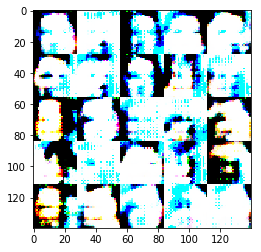

Epoch 1/5... Discriminator_Loss: 2.51210... Generator_Loss: 3.86845
Epoch 1/5... Discriminator_Loss: 0.91813... Generator_Loss: 1.09556
Epoch 1/5... Discriminator_Loss: 1.05497... Generator_Loss: 0.96732
Epoch 1/5... Discriminator_Loss: 1.13855... Generator_Loss: 1.40745
Epoch 1/5... Discriminator_Loss: 1.17092... Generator_Loss: 0.80673


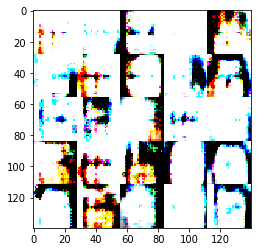

Epoch 1/5... Discriminator_Loss: 0.88674... Generator_Loss: 1.90648
Epoch 1/5... Discriminator_Loss: 0.95320... Generator_Loss: 1.15473
Epoch 1/5... Discriminator_Loss: 1.36136... Generator_Loss: 0.78844
Epoch 1/5... Discriminator_Loss: 1.02988... Generator_Loss: 1.51539
Epoch 1/5... Discriminator_Loss: 0.96253... Generator_Loss: 0.89473


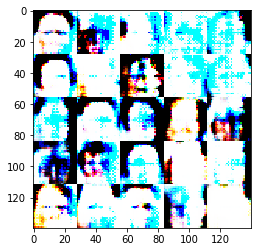

Epoch 1/5... Discriminator_Loss: 1.47197... Generator_Loss: 0.59868
Epoch 1/5... Discriminator_Loss: 1.33825... Generator_Loss: 1.18698
Epoch 1/5... Discriminator_Loss: 0.92028... Generator_Loss: 1.20338
Epoch 1/5... Discriminator_Loss: 1.12481... Generator_Loss: 1.13220
Epoch 1/5... Discriminator_Loss: 1.22878... Generator_Loss: 1.11427


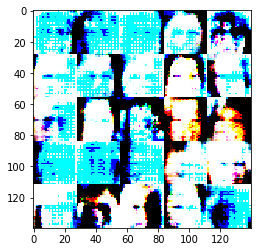

Epoch 1/5... Discriminator_Loss: 4.05907... Generator_Loss: 3.53749
Epoch 1/5... Discriminator_Loss: 1.24372... Generator_Loss: 1.59020
Epoch 1/5... Discriminator_Loss: 0.99382... Generator_Loss: 1.97496
Epoch 1/5... Discriminator_Loss: 2.00476... Generator_Loss: 0.52356
Epoch 1/5... Discriminator_Loss: 1.05511... Generator_Loss: 1.08311


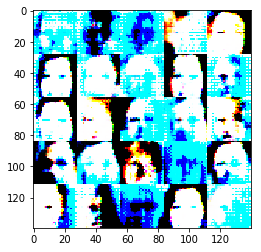

Epoch 1/5... Discriminator_Loss: 0.99413... Generator_Loss: 1.02679
Epoch 1/5... Discriminator_Loss: 1.19221... Generator_Loss: 1.21689
Epoch 1/5... Discriminator_Loss: 1.14117... Generator_Loss: 1.28343
Epoch 1/5... Discriminator_Loss: 0.91650... Generator_Loss: 1.37496
Epoch 1/5... Discriminator_Loss: 1.24189... Generator_Loss: 0.91387


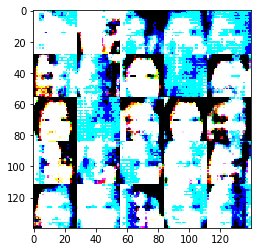

Epoch 1/5... Discriminator_Loss: 0.70252... Generator_Loss: 1.85274
Epoch 1/5... Discriminator_Loss: 0.89351... Generator_Loss: 1.86542
Epoch 1/5... Discriminator_Loss: 1.87398... Generator_Loss: 0.48774
Epoch 1/5... Discriminator_Loss: 0.68381... Generator_Loss: 1.50100
Epoch 1/5... Discriminator_Loss: 1.51218... Generator_Loss: 0.48504


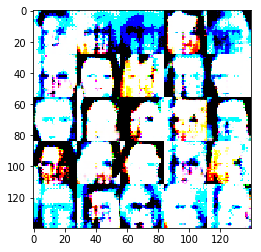

Epoch 1/5... Discriminator_Loss: 0.87287... Generator_Loss: 1.50222
Epoch 1/5... Discriminator_Loss: 1.00126... Generator_Loss: 1.22677
Epoch 1/5... Discriminator_Loss: 1.10678... Generator_Loss: 1.21485
Epoch 1/5... Discriminator_Loss: 1.37225... Generator_Loss: 0.65173
Epoch 1/5... Discriminator_Loss: 1.20872... Generator_Loss: 0.77508


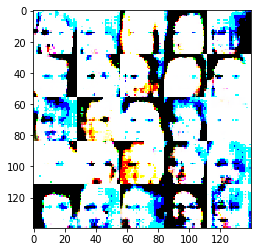

Epoch 1/5... Discriminator_Loss: 0.78746... Generator_Loss: 1.41692
Epoch 1/5... Discriminator_Loss: 0.62404... Generator_Loss: 1.72545
Epoch 1/5... Discriminator_Loss: 1.34426... Generator_Loss: 0.59072
Epoch 1/5... Discriminator_Loss: 1.19059... Generator_Loss: 0.87936
Epoch 1/5... Discriminator_Loss: 0.93287... Generator_Loss: 1.21206


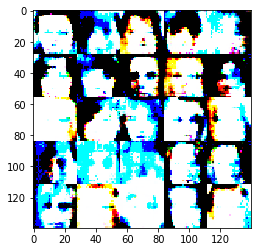

Epoch 1/5... Discriminator_Loss: 1.05539... Generator_Loss: 0.83157
Epoch 1/5... Discriminator_Loss: 1.24895... Generator_Loss: 2.02755
Epoch 1/5... Discriminator_Loss: 1.34017... Generator_Loss: 0.85987
Epoch 1/5... Discriminator_Loss: 0.78775... Generator_Loss: 1.37204
Epoch 1/5... Discriminator_Loss: 1.39088... Generator_Loss: 0.97354


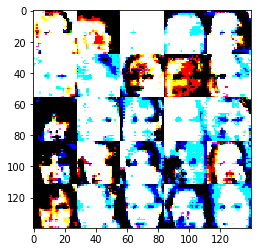

Epoch 1/5... Discriminator_Loss: 0.82875... Generator_Loss: 2.95900
Epoch 1/5... Discriminator_Loss: 1.64680... Generator_Loss: 0.66911
Epoch 1/5... Discriminator_Loss: 1.18010... Generator_Loss: 1.72608
Epoch 1/5... Discriminator_Loss: 1.11067... Generator_Loss: 1.14631
Epoch 1/5... Discriminator_Loss: 3.56375... Generator_Loss: 3.69285


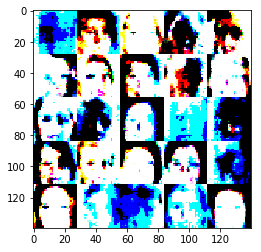

Epoch 1/5... Discriminator_Loss: 0.94527... Generator_Loss: 1.09955
Epoch 2/5... Discriminator_Loss: 1.01976... Generator_Loss: 1.06161
Epoch 2/5... Discriminator_Loss: 0.92513... Generator_Loss: 1.15955
Epoch 2/5... Discriminator_Loss: 1.02944... Generator_Loss: 1.75974
Epoch 2/5... Discriminator_Loss: 0.84197... Generator_Loss: 1.73237


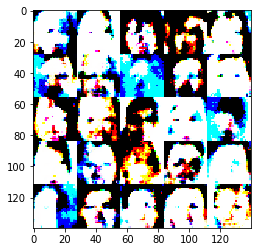

Epoch 2/5... Discriminator_Loss: 1.13611... Generator_Loss: 0.73186
Epoch 2/5... Discriminator_Loss: 0.71410... Generator_Loss: 2.86982
Epoch 2/5... Discriminator_Loss: 0.73304... Generator_Loss: 1.70144
Epoch 2/5... Discriminator_Loss: 1.16133... Generator_Loss: 1.50887
Epoch 2/5... Discriminator_Loss: 0.90677... Generator_Loss: 1.04913


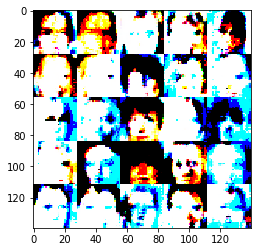

Epoch 2/5... Discriminator_Loss: 1.51162... Generator_Loss: 1.50122
Epoch 2/5... Discriminator_Loss: 1.20887... Generator_Loss: 1.92434
Epoch 2/5... Discriminator_Loss: 0.98572... Generator_Loss: 2.08107
Epoch 2/5... Discriminator_Loss: 1.15674... Generator_Loss: 1.65239
Epoch 2/5... Discriminator_Loss: 1.05851... Generator_Loss: 1.01457


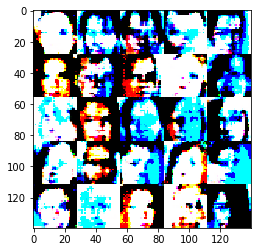

Epoch 2/5... Discriminator_Loss: 0.63251... Generator_Loss: 1.68721
Epoch 2/5... Discriminator_Loss: 1.20938... Generator_Loss: 0.93451
Epoch 2/5... Discriminator_Loss: 1.12975... Generator_Loss: 1.25036
Epoch 2/5... Discriminator_Loss: 1.32774... Generator_Loss: 0.99667
Epoch 2/5... Discriminator_Loss: 1.64738... Generator_Loss: 0.52028


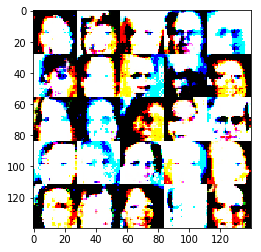

Epoch 2/5... Discriminator_Loss: 1.91442... Generator_Loss: 0.30627
Epoch 2/5... Discriminator_Loss: 0.92853... Generator_Loss: 1.76995
Epoch 2/5... Discriminator_Loss: 2.16381... Generator_Loss: 3.32964
Epoch 2/5... Discriminator_Loss: 0.95823... Generator_Loss: 1.51652
Epoch 2/5... Discriminator_Loss: 1.33407... Generator_Loss: 1.04094


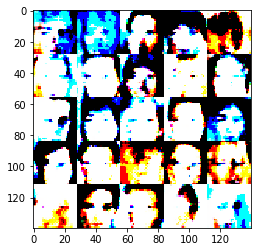

Epoch 2/5... Discriminator_Loss: 1.93962... Generator_Loss: 0.34800
Epoch 2/5... Discriminator_Loss: 1.40169... Generator_Loss: 1.51434
Epoch 2/5... Discriminator_Loss: 0.56815... Generator_Loss: 2.00593
Epoch 2/5... Discriminator_Loss: 1.29951... Generator_Loss: 2.42664
Epoch 2/5... Discriminator_Loss: 1.37910... Generator_Loss: 0.70300


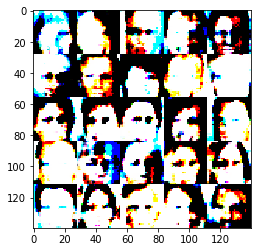

Epoch 2/5... Discriminator_Loss: 0.95543... Generator_Loss: 1.07075
Epoch 2/5... Discriminator_Loss: 1.38622... Generator_Loss: 0.52388
Epoch 2/5... Discriminator_Loss: 1.11981... Generator_Loss: 0.94418
Epoch 2/5... Discriminator_Loss: 1.34201... Generator_Loss: 0.61991
Epoch 2/5... Discriminator_Loss: 0.95244... Generator_Loss: 1.26417


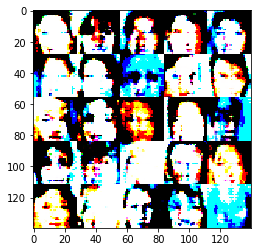

Epoch 2/5... Discriminator_Loss: 1.40963... Generator_Loss: 0.61759
Epoch 2/5... Discriminator_Loss: 1.16262... Generator_Loss: 0.99722
Epoch 2/5... Discriminator_Loss: 1.41378... Generator_Loss: 0.71515
Epoch 2/5... Discriminator_Loss: 1.15006... Generator_Loss: 1.11862
Epoch 2/5... Discriminator_Loss: 1.02502... Generator_Loss: 1.21053


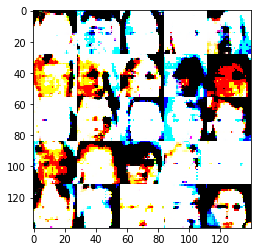

Epoch 2/5... Discriminator_Loss: 1.33409... Generator_Loss: 0.80552
Epoch 2/5... Discriminator_Loss: 1.11357... Generator_Loss: 1.05902
Epoch 2/5... Discriminator_Loss: 1.04159... Generator_Loss: 1.46340
Epoch 2/5... Discriminator_Loss: 0.96796... Generator_Loss: 1.33197
Epoch 2/5... Discriminator_Loss: 1.57509... Generator_Loss: 0.47875


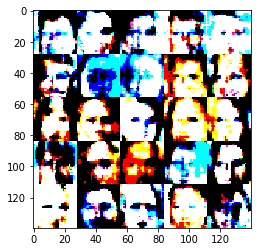

Epoch 2/5... Discriminator_Loss: 0.88912... Generator_Loss: 1.43507
Epoch 2/5... Discriminator_Loss: 0.82324... Generator_Loss: 1.10991
Epoch 2/5... Discriminator_Loss: 1.38548... Generator_Loss: 0.89186
Epoch 2/5... Discriminator_Loss: 1.13591... Generator_Loss: 1.05760
Epoch 2/5... Discriminator_Loss: 1.21097... Generator_Loss: 0.92911


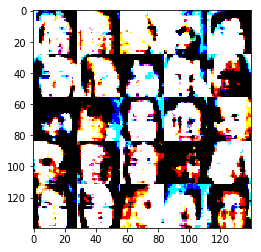

Epoch 2/5... Discriminator_Loss: 1.47442... Generator_Loss: 2.72955
Epoch 2/5... Discriminator_Loss: 1.67758... Generator_Loss: 2.36093
Epoch 2/5... Discriminator_Loss: 2.14708... Generator_Loss: 2.66945
Epoch 2/5... Discriminator_Loss: 0.90356... Generator_Loss: 1.78737
Epoch 2/5... Discriminator_Loss: 1.22546... Generator_Loss: 1.24690


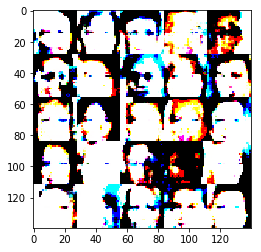

Epoch 2/5... Discriminator_Loss: 2.34973... Generator_Loss: 0.18795
Epoch 2/5... Discriminator_Loss: 1.46782... Generator_Loss: 0.51385
Epoch 2/5... Discriminator_Loss: 0.77017... Generator_Loss: 1.34149
Epoch 2/5... Discriminator_Loss: 1.13098... Generator_Loss: 1.08637
Epoch 2/5... Discriminator_Loss: 0.82415... Generator_Loss: 1.54343


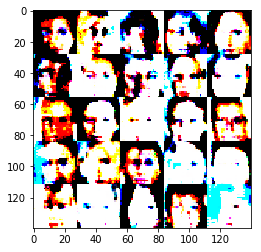

Epoch 2/5... Discriminator_Loss: 1.08274... Generator_Loss: 0.94932
Epoch 2/5... Discriminator_Loss: 0.89638... Generator_Loss: 0.99929
Epoch 2/5... Discriminator_Loss: 0.65603... Generator_Loss: 1.71315
Epoch 2/5... Discriminator_Loss: 1.82466... Generator_Loss: 3.52207
Epoch 2/5... Discriminator_Loss: 1.32475... Generator_Loss: 0.77468


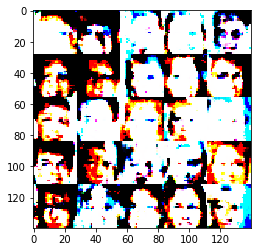

Epoch 2/5... Discriminator_Loss: 1.15685... Generator_Loss: 1.09817
Epoch 2/5... Discriminator_Loss: 1.12193... Generator_Loss: 1.29883
Epoch 2/5... Discriminator_Loss: 1.29405... Generator_Loss: 0.59766
Epoch 2/5... Discriminator_Loss: 1.12177... Generator_Loss: 0.78601
Epoch 2/5... Discriminator_Loss: 0.89432... Generator_Loss: 1.38966


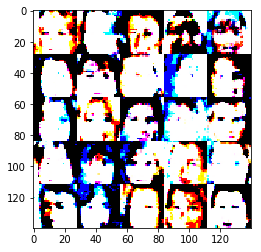

Epoch 2/5... Discriminator_Loss: 1.23136... Generator_Loss: 0.94507
Epoch 2/5... Discriminator_Loss: 1.08317... Generator_Loss: 1.11505
Epoch 2/5... Discriminator_Loss: 1.22259... Generator_Loss: 0.77678
Epoch 2/5... Discriminator_Loss: 1.36255... Generator_Loss: 0.66040
Epoch 2/5... Discriminator_Loss: 1.00786... Generator_Loss: 0.98720


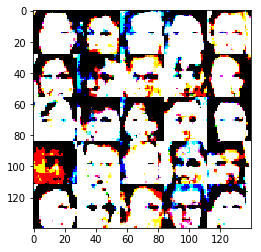

Epoch 2/5... Discriminator_Loss: 0.93419... Generator_Loss: 1.69660
Epoch 2/5... Discriminator_Loss: 1.11145... Generator_Loss: 1.02818
Epoch 2/5... Discriminator_Loss: 1.12942... Generator_Loss: 0.98737
Epoch 2/5... Discriminator_Loss: 1.09909... Generator_Loss: 1.37294
Epoch 2/5... Discriminator_Loss: 1.48253... Generator_Loss: 1.95644


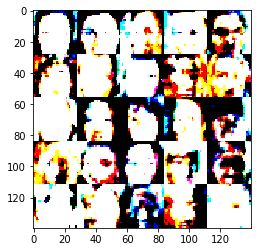

Epoch 2/5... Discriminator_Loss: 1.08088... Generator_Loss: 1.00328
Epoch 2/5... Discriminator_Loss: 0.74396... Generator_Loss: 1.38133
Epoch 2/5... Discriminator_Loss: 1.08347... Generator_Loss: 0.96597
Epoch 2/5... Discriminator_Loss: 0.89932... Generator_Loss: 0.96654
Epoch 2/5... Discriminator_Loss: 1.26355... Generator_Loss: 0.75121


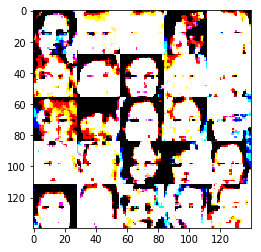

Epoch 2/5... Discriminator_Loss: 1.41184... Generator_Loss: 0.50311
Epoch 2/5... Discriminator_Loss: 1.08949... Generator_Loss: 1.41968
Epoch 2/5... Discriminator_Loss: 1.23420... Generator_Loss: 0.71133
Epoch 2/5... Discriminator_Loss: 1.37696... Generator_Loss: 1.07286
Epoch 2/5... Discriminator_Loss: 1.31827... Generator_Loss: 0.83330


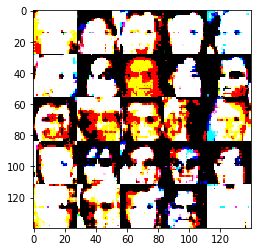

Epoch 2/5... Discriminator_Loss: 1.09155... Generator_Loss: 1.12276
Epoch 2/5... Discriminator_Loss: 1.21040... Generator_Loss: 0.76857
Epoch 2/5... Discriminator_Loss: 1.53488... Generator_Loss: 0.59367
Epoch 2/5... Discriminator_Loss: 1.24633... Generator_Loss: 0.79706
Epoch 2/5... Discriminator_Loss: 1.06082... Generator_Loss: 1.21899


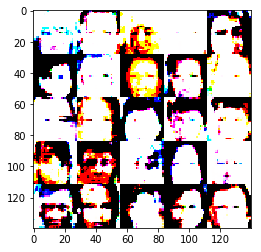

Epoch 2/5... Discriminator_Loss: 1.37466... Generator_Loss: 0.58042
Epoch 2/5... Discriminator_Loss: 1.29153... Generator_Loss: 0.86261
Epoch 2/5... Discriminator_Loss: 1.25105... Generator_Loss: 0.61398
Epoch 2/5... Discriminator_Loss: 0.96296... Generator_Loss: 1.69106
Epoch 2/5... Discriminator_Loss: 1.39686... Generator_Loss: 0.54502


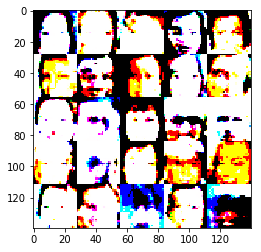

Epoch 2/5... Discriminator_Loss: 1.28671... Generator_Loss: 0.80004
Epoch 2/5... Discriminator_Loss: 1.28839... Generator_Loss: 1.26526
Epoch 3/5... Discriminator_Loss: 1.38716... Generator_Loss: 0.51979
Epoch 3/5... Discriminator_Loss: 1.66435... Generator_Loss: 2.17148
Epoch 3/5... Discriminator_Loss: 1.10793... Generator_Loss: 1.49314


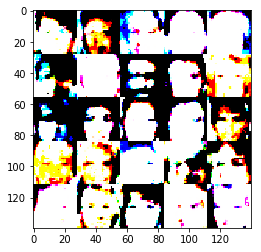

Epoch 3/5... Discriminator_Loss: 1.15468... Generator_Loss: 0.78869
Epoch 3/5... Discriminator_Loss: 1.18266... Generator_Loss: 0.85863
Epoch 3/5... Discriminator_Loss: 1.19154... Generator_Loss: 1.22942
Epoch 3/5... Discriminator_Loss: 1.34422... Generator_Loss: 0.88304
Epoch 3/5... Discriminator_Loss: 1.50337... Generator_Loss: 2.46946


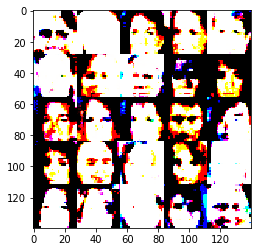

Epoch 3/5... Discriminator_Loss: 1.07713... Generator_Loss: 1.27740
Epoch 3/5... Discriminator_Loss: 1.09775... Generator_Loss: 0.84868
Epoch 3/5... Discriminator_Loss: 1.17533... Generator_Loss: 0.92233
Epoch 3/5... Discriminator_Loss: 1.78910... Generator_Loss: 0.34964
Epoch 3/5... Discriminator_Loss: 1.18541... Generator_Loss: 0.98875


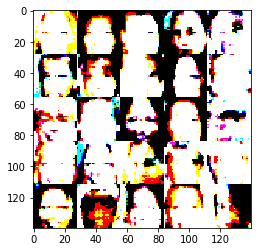

Epoch 3/5... Discriminator_Loss: 1.11409... Generator_Loss: 1.04720
Epoch 3/5... Discriminator_Loss: 1.15452... Generator_Loss: 0.74365
Epoch 3/5... Discriminator_Loss: 1.48271... Generator_Loss: 1.70725
Epoch 3/5... Discriminator_Loss: 0.99880... Generator_Loss: 0.92345
Epoch 3/5... Discriminator_Loss: 1.02678... Generator_Loss: 1.42076


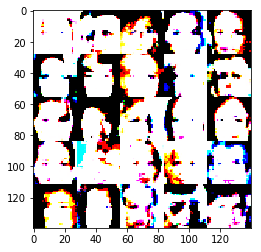

Epoch 3/5... Discriminator_Loss: 0.83860... Generator_Loss: 1.64092
Epoch 3/5... Discriminator_Loss: 1.24316... Generator_Loss: 0.77792
Epoch 3/5... Discriminator_Loss: 0.76798... Generator_Loss: 1.64187
Epoch 3/5... Discriminator_Loss: 0.79480... Generator_Loss: 1.22631
Epoch 3/5... Discriminator_Loss: 1.17861... Generator_Loss: 1.20920


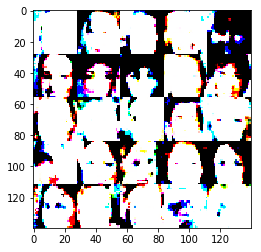

Epoch 3/5... Discriminator_Loss: 1.40386... Generator_Loss: 0.55677
Epoch 3/5... Discriminator_Loss: 0.74476... Generator_Loss: 1.66086
Epoch 3/5... Discriminator_Loss: 1.08228... Generator_Loss: 1.02941
Epoch 3/5... Discriminator_Loss: 1.43774... Generator_Loss: 0.54848
Epoch 3/5... Discriminator_Loss: 1.21191... Generator_Loss: 0.84506


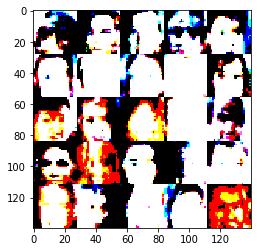

Epoch 3/5... Discriminator_Loss: 1.85280... Generator_Loss: 1.92618
Epoch 3/5... Discriminator_Loss: 1.62293... Generator_Loss: 0.92423
Epoch 3/5... Discriminator_Loss: 3.34709... Generator_Loss: 4.20748
Epoch 3/5... Discriminator_Loss: 1.28353... Generator_Loss: 1.17861
Epoch 3/5... Discriminator_Loss: 1.35998... Generator_Loss: 0.56632


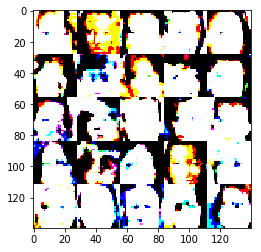

Epoch 3/5... Discriminator_Loss: 1.35677... Generator_Loss: 1.84689
Epoch 3/5... Discriminator_Loss: 1.25002... Generator_Loss: 0.75891
Epoch 3/5... Discriminator_Loss: 1.15522... Generator_Loss: 1.06986
Epoch 3/5... Discriminator_Loss: 1.18741... Generator_Loss: 1.86940
Epoch 3/5... Discriminator_Loss: 1.03714... Generator_Loss: 1.13396


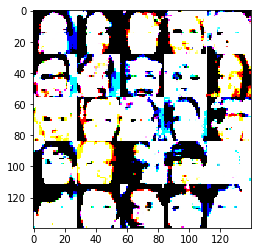

Epoch 3/5... Discriminator_Loss: 1.09910... Generator_Loss: 1.34178
Epoch 3/5... Discriminator_Loss: 1.28449... Generator_Loss: 0.60780
Epoch 3/5... Discriminator_Loss: 1.32634... Generator_Loss: 0.91674
Epoch 3/5... Discriminator_Loss: 1.32471... Generator_Loss: 0.55796
Epoch 3/5... Discriminator_Loss: 1.22228... Generator_Loss: 0.70078


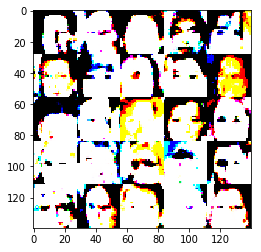

Epoch 3/5... Discriminator_Loss: 1.19271... Generator_Loss: 0.79510
Epoch 3/5... Discriminator_Loss: 1.17446... Generator_Loss: 1.09682
Epoch 3/5... Discriminator_Loss: 1.22563... Generator_Loss: 0.87249
Epoch 3/5... Discriminator_Loss: 1.11678... Generator_Loss: 0.99497
Epoch 3/5... Discriminator_Loss: 1.05962... Generator_Loss: 1.23057


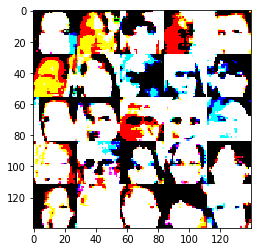

Epoch 3/5... Discriminator_Loss: 1.25099... Generator_Loss: 0.82984
Epoch 3/5... Discriminator_Loss: 1.09663... Generator_Loss: 1.14304
Epoch 3/5... Discriminator_Loss: 1.14561... Generator_Loss: 1.03589
Epoch 3/5... Discriminator_Loss: 1.23019... Generator_Loss: 0.81066
Epoch 3/5... Discriminator_Loss: 1.20239... Generator_Loss: 0.77547


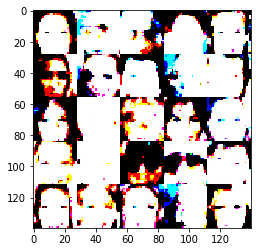

Epoch 3/5... Discriminator_Loss: 1.08896... Generator_Loss: 1.36152
Epoch 3/5... Discriminator_Loss: 0.98956... Generator_Loss: 1.11020
Epoch 3/5... Discriminator_Loss: 1.20668... Generator_Loss: 1.08857
Epoch 3/5... Discriminator_Loss: 1.13533... Generator_Loss: 0.79777
Epoch 3/5... Discriminator_Loss: 1.16395... Generator_Loss: 0.98082


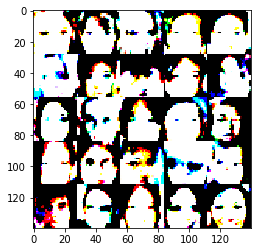

Epoch 3/5... Discriminator_Loss: 1.30024... Generator_Loss: 0.74274
Epoch 3/5... Discriminator_Loss: 1.14066... Generator_Loss: 0.83027
Epoch 3/5... Discriminator_Loss: 2.00979... Generator_Loss: 2.91771
Epoch 3/5... Discriminator_Loss: 1.16161... Generator_Loss: 1.11547
Epoch 3/5... Discriminator_Loss: 1.14316... Generator_Loss: 1.66698


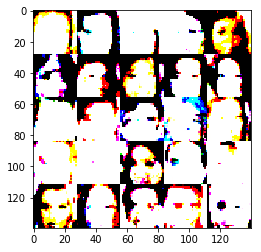

Epoch 3/5... Discriminator_Loss: 1.13216... Generator_Loss: 1.08091
Epoch 3/5... Discriminator_Loss: 1.16509... Generator_Loss: 0.75196
Epoch 3/5... Discriminator_Loss: 0.50352... Generator_Loss: 2.26698
Epoch 3/5... Discriminator_Loss: 1.36102... Generator_Loss: 0.97570
Epoch 3/5... Discriminator_Loss: 1.34491... Generator_Loss: 0.89798


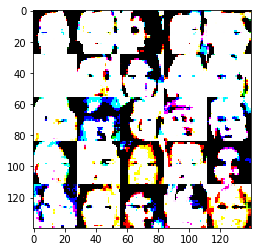

Epoch 3/5... Discriminator_Loss: 1.39329... Generator_Loss: 0.62560
Epoch 3/5... Discriminator_Loss: 1.23347... Generator_Loss: 0.96627
Epoch 3/5... Discriminator_Loss: 1.19011... Generator_Loss: 0.88659
Epoch 3/5... Discriminator_Loss: 1.38535... Generator_Loss: 1.46888
Epoch 3/5... Discriminator_Loss: 1.24446... Generator_Loss: 0.80023


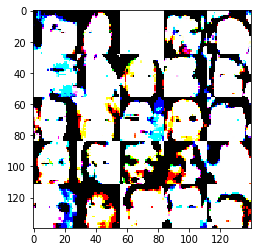

Epoch 3/5... Discriminator_Loss: 1.20535... Generator_Loss: 1.28525
Epoch 3/5... Discriminator_Loss: 1.31791... Generator_Loss: 0.70362
Epoch 3/5... Discriminator_Loss: 1.19907... Generator_Loss: 0.94352
Epoch 3/5... Discriminator_Loss: 0.57579... Generator_Loss: 1.74343
Epoch 3/5... Discriminator_Loss: 0.96916... Generator_Loss: 0.93195


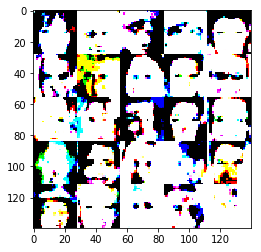

Epoch 3/5... Discriminator_Loss: 0.95248... Generator_Loss: 2.10432
Epoch 3/5... Discriminator_Loss: 0.95285... Generator_Loss: 1.56348
Epoch 3/5... Discriminator_Loss: 1.22146... Generator_Loss: 0.67456
Epoch 3/5... Discriminator_Loss: 0.54065... Generator_Loss: 3.09505
Epoch 3/5... Discriminator_Loss: 1.41663... Generator_Loss: 1.34955


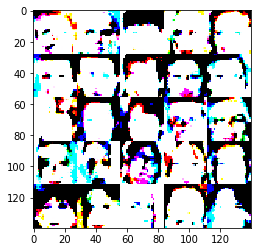

Epoch 3/5... Discriminator_Loss: 1.63621... Generator_Loss: 0.39107
Epoch 3/5... Discriminator_Loss: 1.47358... Generator_Loss: 0.49835
Epoch 3/5... Discriminator_Loss: 0.96034... Generator_Loss: 1.53065
Epoch 3/5... Discriminator_Loss: 1.25959... Generator_Loss: 0.71263
Epoch 3/5... Discriminator_Loss: 0.99611... Generator_Loss: 0.83116


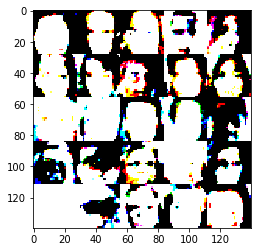

Epoch 3/5... Discriminator_Loss: 1.29853... Generator_Loss: 1.01042
Epoch 3/5... Discriminator_Loss: 1.32607... Generator_Loss: 0.56624
Epoch 3/5... Discriminator_Loss: 1.08536... Generator_Loss: 1.48841
Epoch 3/5... Discriminator_Loss: 1.47029... Generator_Loss: 0.52835
Epoch 3/5... Discriminator_Loss: 1.30975... Generator_Loss: 0.60368


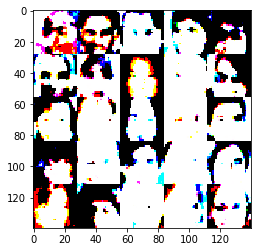

Epoch 3/5... Discriminator_Loss: 1.10256... Generator_Loss: 1.30122
Epoch 3/5... Discriminator_Loss: 1.22579... Generator_Loss: 0.84641
Epoch 3/5... Discriminator_Loss: 1.25999... Generator_Loss: 0.93662
Epoch 3/5... Discriminator_Loss: 1.23974... Generator_Loss: 0.96556
Epoch 3/5... Discriminator_Loss: 1.32957... Generator_Loss: 0.71892


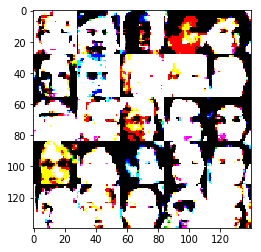

Epoch 3/5... Discriminator_Loss: 1.15832... Generator_Loss: 1.00164
Epoch 3/5... Discriminator_Loss: 1.15802... Generator_Loss: 1.16638
Epoch 3/5... Discriminator_Loss: 1.38233... Generator_Loss: 0.67830
Epoch 4/5... Discriminator_Loss: 1.09018... Generator_Loss: 1.18202
Epoch 4/5... Discriminator_Loss: 1.34362... Generator_Loss: 1.66449


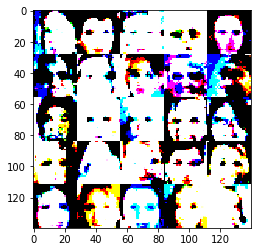

Epoch 4/5... Discriminator_Loss: 1.31197... Generator_Loss: 0.57848
Epoch 4/5... Discriminator_Loss: 1.11824... Generator_Loss: 0.94315
Epoch 4/5... Discriminator_Loss: 1.26704... Generator_Loss: 0.98036
Epoch 4/5... Discriminator_Loss: 1.73915... Generator_Loss: 0.36243
Epoch 4/5... Discriminator_Loss: 0.99391... Generator_Loss: 1.41805


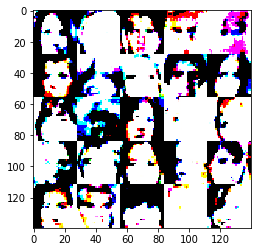

Epoch 4/5... Discriminator_Loss: 1.08498... Generator_Loss: 1.08824
Epoch 4/5... Discriminator_Loss: 1.28021... Generator_Loss: 1.12675
Epoch 4/5... Discriminator_Loss: 1.29996... Generator_Loss: 0.68336
Epoch 4/5... Discriminator_Loss: 1.16547... Generator_Loss: 1.06759
Epoch 4/5... Discriminator_Loss: 1.27243... Generator_Loss: 1.26538


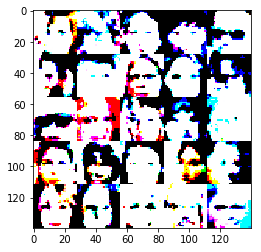

Epoch 4/5... Discriminator_Loss: 1.24154... Generator_Loss: 0.94347
Epoch 4/5... Discriminator_Loss: 1.46482... Generator_Loss: 2.34127
Epoch 4/5... Discriminator_Loss: 1.31805... Generator_Loss: 0.84419
Epoch 4/5... Discriminator_Loss: 1.35440... Generator_Loss: 0.84343
Epoch 4/5... Discriminator_Loss: 1.18947... Generator_Loss: 0.84401


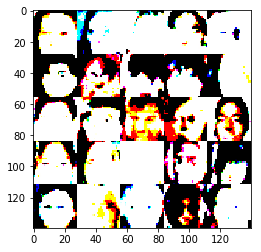

Epoch 4/5... Discriminator_Loss: 1.12766... Generator_Loss: 0.96200
Epoch 4/5... Discriminator_Loss: 2.03672... Generator_Loss: 2.79555
Epoch 4/5... Discriminator_Loss: 1.08743... Generator_Loss: 1.29482
Epoch 4/5... Discriminator_Loss: 1.25367... Generator_Loss: 1.46145
Epoch 4/5... Discriminator_Loss: 1.21073... Generator_Loss: 1.36624


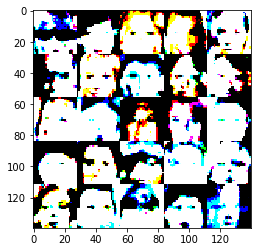

Epoch 4/5... Discriminator_Loss: 1.08108... Generator_Loss: 1.10056
Epoch 4/5... Discriminator_Loss: 1.10557... Generator_Loss: 0.92978
Epoch 4/5... Discriminator_Loss: 1.24325... Generator_Loss: 1.66601
Epoch 4/5... Discriminator_Loss: 1.09036... Generator_Loss: 0.98545
Epoch 4/5... Discriminator_Loss: 1.10928... Generator_Loss: 1.18261


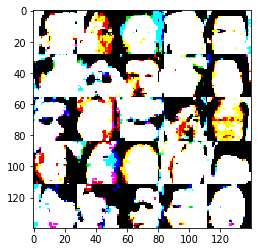

Epoch 4/5... Discriminator_Loss: 1.37492... Generator_Loss: 0.55618
Epoch 4/5... Discriminator_Loss: 1.15986... Generator_Loss: 0.87338
Epoch 4/5... Discriminator_Loss: 1.26957... Generator_Loss: 0.75666
Epoch 4/5... Discriminator_Loss: 1.16228... Generator_Loss: 0.84248
Epoch 4/5... Discriminator_Loss: 1.32910... Generator_Loss: 0.68307


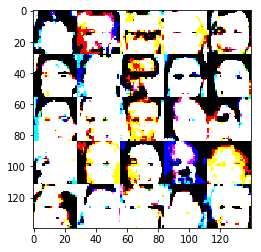

Epoch 4/5... Discriminator_Loss: 1.28260... Generator_Loss: 0.73832
Epoch 4/5... Discriminator_Loss: 1.27187... Generator_Loss: 0.77288
Epoch 4/5... Discriminator_Loss: 1.27561... Generator_Loss: 0.63879
Epoch 4/5... Discriminator_Loss: 1.37631... Generator_Loss: 1.65394
Epoch 4/5... Discriminator_Loss: 1.28259... Generator_Loss: 0.69012


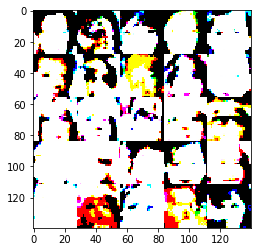

Epoch 4/5... Discriminator_Loss: 1.23943... Generator_Loss: 0.75430
Epoch 4/5... Discriminator_Loss: 1.70906... Generator_Loss: 0.35314
Epoch 4/5... Discriminator_Loss: 1.30332... Generator_Loss: 0.69249
Epoch 4/5... Discriminator_Loss: 1.26116... Generator_Loss: 0.86755
Epoch 4/5... Discriminator_Loss: 1.27486... Generator_Loss: 1.27411


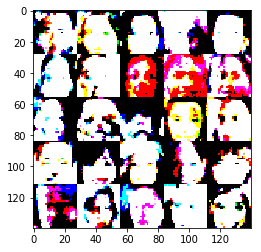

Epoch 4/5... Discriminator_Loss: 2.32245... Generator_Loss: 2.81826
Epoch 4/5... Discriminator_Loss: 1.16969... Generator_Loss: 1.32197
Epoch 4/5... Discriminator_Loss: 1.23257... Generator_Loss: 0.77549
Epoch 4/5... Discriminator_Loss: 1.18320... Generator_Loss: 0.83099
Epoch 4/5... Discriminator_Loss: 1.53471... Generator_Loss: 1.94688


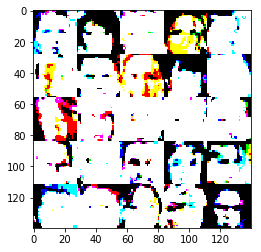

Epoch 4/5... Discriminator_Loss: 1.19033... Generator_Loss: 0.76492
Epoch 4/5... Discriminator_Loss: 1.69544... Generator_Loss: 0.38414
Epoch 4/5... Discriminator_Loss: 0.80941... Generator_Loss: 1.15089
Epoch 4/5... Discriminator_Loss: 1.20224... Generator_Loss: 0.93371
Epoch 4/5... Discriminator_Loss: 1.12434... Generator_Loss: 1.67338


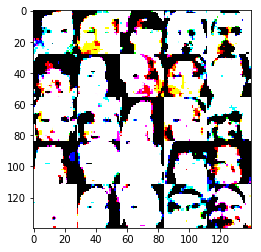

Epoch 4/5... Discriminator_Loss: 1.42026... Generator_Loss: 1.67195
Epoch 4/5... Discriminator_Loss: 1.17377... Generator_Loss: 1.37659
Epoch 4/5... Discriminator_Loss: 1.08948... Generator_Loss: 1.04509
Epoch 4/5... Discriminator_Loss: 0.96836... Generator_Loss: 1.97333
Epoch 4/5... Discriminator_Loss: 1.43359... Generator_Loss: 1.85285


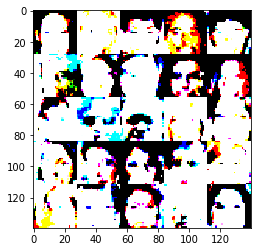

Epoch 4/5... Discriminator_Loss: 1.28723... Generator_Loss: 0.57171
Epoch 4/5... Discriminator_Loss: 1.45217... Generator_Loss: 0.43393
Epoch 4/5... Discriminator_Loss: 0.40345... Generator_Loss: 3.09933
Epoch 4/5... Discriminator_Loss: 1.13850... Generator_Loss: 1.68959
Epoch 4/5... Discriminator_Loss: 1.06222... Generator_Loss: 0.87383


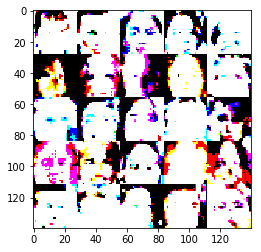

Epoch 4/5... Discriminator_Loss: 1.63537... Generator_Loss: 0.50243
Epoch 4/5... Discriminator_Loss: 1.07542... Generator_Loss: 1.23795
Epoch 4/5... Discriminator_Loss: 0.78388... Generator_Loss: 1.24283
Epoch 4/5... Discriminator_Loss: 0.61432... Generator_Loss: 1.61561
Epoch 4/5... Discriminator_Loss: 2.55382... Generator_Loss: 3.22204


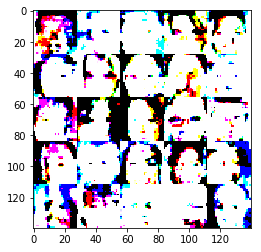

Epoch 4/5... Discriminator_Loss: 0.86819... Generator_Loss: 1.30752
Epoch 4/5... Discriminator_Loss: 0.98658... Generator_Loss: 1.20857
Epoch 4/5... Discriminator_Loss: 0.68401... Generator_Loss: 1.38092
Epoch 4/5... Discriminator_Loss: 1.05315... Generator_Loss: 1.98441
Epoch 4/5... Discriminator_Loss: 1.03498... Generator_Loss: 1.11119


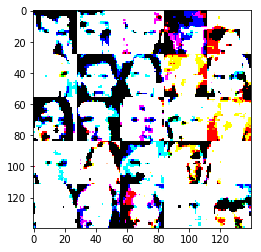

Epoch 4/5... Discriminator_Loss: 1.10498... Generator_Loss: 0.81883
Epoch 4/5... Discriminator_Loss: 1.40721... Generator_Loss: 0.66341
Epoch 4/5... Discriminator_Loss: 1.49246... Generator_Loss: 1.78804
Epoch 4/5... Discriminator_Loss: 0.91639... Generator_Loss: 1.33223
Epoch 4/5... Discriminator_Loss: 1.09774... Generator_Loss: 1.03272


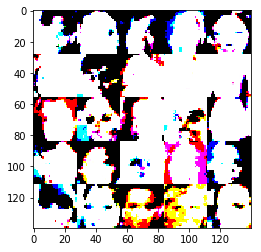

Epoch 4/5... Discriminator_Loss: 1.19764... Generator_Loss: 0.74527
Epoch 4/5... Discriminator_Loss: 1.20554... Generator_Loss: 0.95028
Epoch 4/5... Discriminator_Loss: 1.16506... Generator_Loss: 1.01756
Epoch 4/5... Discriminator_Loss: 1.17344... Generator_Loss: 0.97039
Epoch 4/5... Discriminator_Loss: 1.48776... Generator_Loss: 0.46487


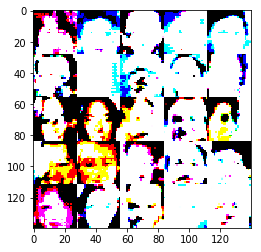

Epoch 4/5... Discriminator_Loss: 1.19309... Generator_Loss: 1.07053
Epoch 4/5... Discriminator_Loss: 1.22562... Generator_Loss: 0.69118
Epoch 4/5... Discriminator_Loss: 1.14001... Generator_Loss: 0.93308
Epoch 4/5... Discriminator_Loss: 1.21489... Generator_Loss: 1.34946
Epoch 4/5... Discriminator_Loss: 1.31372... Generator_Loss: 0.65707


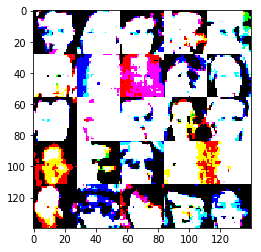

Epoch 4/5... Discriminator_Loss: 1.29680... Generator_Loss: 0.91669
Epoch 4/5... Discriminator_Loss: 1.08121... Generator_Loss: 0.89302
Epoch 4/5... Discriminator_Loss: 1.23489... Generator_Loss: 0.88418
Epoch 4/5... Discriminator_Loss: 1.31224... Generator_Loss: 1.17562
Epoch 4/5... Discriminator_Loss: 1.33217... Generator_Loss: 0.79521


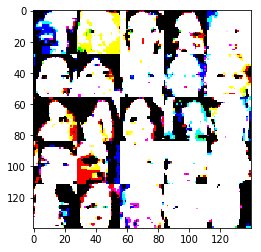

Epoch 4/5... Discriminator_Loss: 1.25380... Generator_Loss: 0.87523
Epoch 4/5... Discriminator_Loss: 1.68481... Generator_Loss: 2.44315
Epoch 4/5... Discriminator_Loss: 1.70937... Generator_Loss: 2.36665
Epoch 4/5... Discriminator_Loss: 1.21833... Generator_Loss: 1.15653
Epoch 4/5... Discriminator_Loss: 1.48593... Generator_Loss: 0.50930


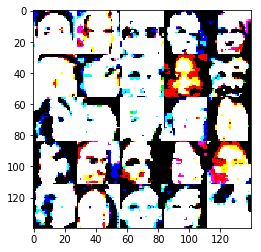

Epoch 4/5... Discriminator_Loss: 1.19252... Generator_Loss: 0.86705
Epoch 4/5... Discriminator_Loss: 1.22638... Generator_Loss: 0.67322
Epoch 4/5... Discriminator_Loss: 1.05352... Generator_Loss: 0.96367
Epoch 4/5... Discriminator_Loss: 0.83039... Generator_Loss: 1.04554
Epoch 4/5... Discriminator_Loss: 1.38699... Generator_Loss: 0.52793


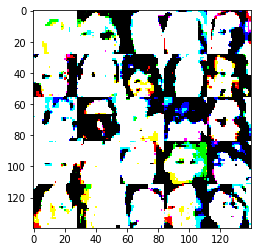

Epoch 5/5... Discriminator_Loss: 1.05846... Generator_Loss: 1.99485
Epoch 5/5... Discriminator_Loss: 1.35637... Generator_Loss: 0.54965
Epoch 5/5... Discriminator_Loss: 1.26010... Generator_Loss: 1.31993
Epoch 5/5... Discriminator_Loss: 1.35431... Generator_Loss: 0.66026
Epoch 5/5... Discriminator_Loss: 1.16182... Generator_Loss: 0.84168


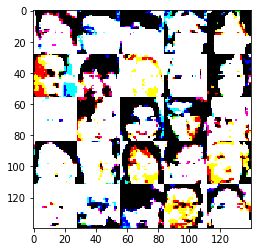

Epoch 5/5... Discriminator_Loss: 1.19326... Generator_Loss: 1.15000
Epoch 5/5... Discriminator_Loss: 1.08304... Generator_Loss: 1.20897
Epoch 5/5... Discriminator_Loss: 1.17865... Generator_Loss: 1.30283
Epoch 5/5... Discriminator_Loss: 1.26287... Generator_Loss: 0.75421
Epoch 5/5... Discriminator_Loss: 1.19741... Generator_Loss: 0.78992


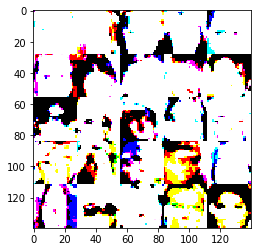

Epoch 5/5... Discriminator_Loss: 1.22079... Generator_Loss: 0.74963
Epoch 5/5... Discriminator_Loss: 1.46738... Generator_Loss: 0.47785
Epoch 5/5... Discriminator_Loss: 1.19298... Generator_Loss: 0.76108
Epoch 5/5... Discriminator_Loss: 1.17108... Generator_Loss: 0.88887
Epoch 5/5... Discriminator_Loss: 0.84724... Generator_Loss: 3.06446


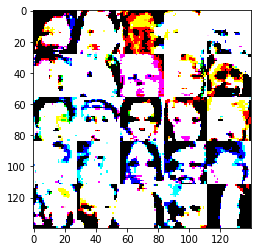

Epoch 5/5... Discriminator_Loss: 1.03091... Generator_Loss: 1.24389
Epoch 5/5... Discriminator_Loss: 0.99809... Generator_Loss: 0.80969
Epoch 5/5... Discriminator_Loss: 2.34473... Generator_Loss: 0.17460
Epoch 5/5... Discriminator_Loss: 1.15641... Generator_Loss: 1.24757
Epoch 5/5... Discriminator_Loss: 1.20530... Generator_Loss: 1.02333


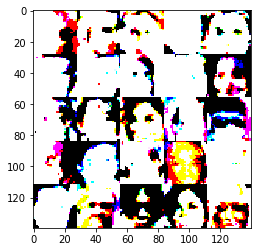

Epoch 5/5... Discriminator_Loss: 1.21093... Generator_Loss: 0.85082
Epoch 5/5... Discriminator_Loss: 1.14693... Generator_Loss: 0.93602
Epoch 5/5... Discriminator_Loss: 1.22456... Generator_Loss: 0.71134
Epoch 5/5... Discriminator_Loss: 1.24204... Generator_Loss: 0.75752
Epoch 5/5... Discriminator_Loss: 1.53745... Generator_Loss: 0.55546


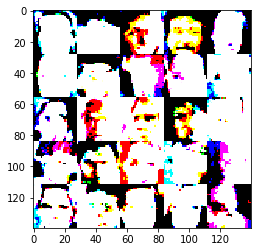

Epoch 5/5... Discriminator_Loss: 1.21793... Generator_Loss: 0.97435
Epoch 5/5... Discriminator_Loss: 1.35322... Generator_Loss: 1.19475
Epoch 5/5... Discriminator_Loss: 1.27552... Generator_Loss: 1.28103
Epoch 5/5... Discriminator_Loss: 1.32792... Generator_Loss: 1.38440
Epoch 5/5... Discriminator_Loss: 1.32339... Generator_Loss: 0.62849


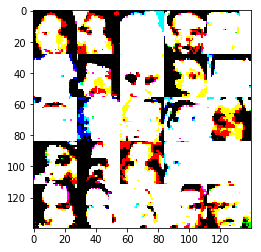

Epoch 5/5... Discriminator_Loss: 1.16635... Generator_Loss: 1.18391
Epoch 5/5... Discriminator_Loss: 1.26375... Generator_Loss: 0.65525
Epoch 5/5... Discriminator_Loss: 1.13858... Generator_Loss: 1.12139
Epoch 5/5... Discriminator_Loss: 1.20305... Generator_Loss: 0.71114
Epoch 5/5... Discriminator_Loss: 1.10545... Generator_Loss: 1.13812


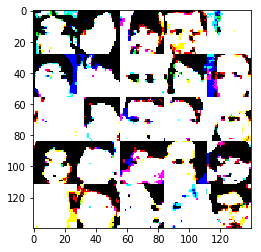

Epoch 5/5... Discriminator_Loss: 1.12466... Generator_Loss: 0.95843
Epoch 5/5... Discriminator_Loss: 1.25339... Generator_Loss: 0.68290
Epoch 5/5... Discriminator_Loss: 1.26413... Generator_Loss: 1.29607
Epoch 5/5... Discriminator_Loss: 1.53994... Generator_Loss: 0.44917
Epoch 5/5... Discriminator_Loss: 1.16913... Generator_Loss: 0.92014


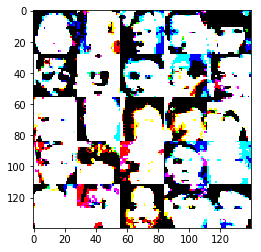

Epoch 5/5... Discriminator_Loss: 1.35172... Generator_Loss: 1.46159
Epoch 5/5... Discriminator_Loss: 1.10397... Generator_Loss: 1.06940
Epoch 5/5... Discriminator_Loss: 1.26963... Generator_Loss: 0.84597
Epoch 5/5... Discriminator_Loss: 1.20224... Generator_Loss: 0.67895
Epoch 5/5... Discriminator_Loss: 1.13884... Generator_Loss: 1.12188


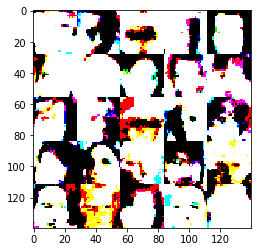

Epoch 5/5... Discriminator_Loss: 1.16226... Generator_Loss: 1.42589
Epoch 5/5... Discriminator_Loss: 1.29296... Generator_Loss: 0.77722
Epoch 5/5... Discriminator_Loss: 1.20167... Generator_Loss: 0.94325
Epoch 5/5... Discriminator_Loss: 1.23115... Generator_Loss: 0.84861
Epoch 5/5... Discriminator_Loss: 1.32780... Generator_Loss: 1.47905


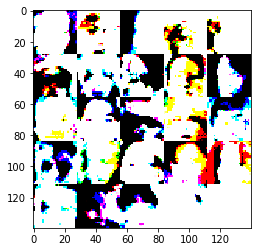

Epoch 5/5... Discriminator_Loss: 1.14287... Generator_Loss: 1.07896
Epoch 5/5... Discriminator_Loss: 1.18228... Generator_Loss: 0.78694
Epoch 5/5... Discriminator_Loss: 1.31970... Generator_Loss: 1.67686
Epoch 5/5... Discriminator_Loss: 1.21363... Generator_Loss: 0.85485
Epoch 5/5... Discriminator_Loss: 0.46303... Generator_Loss: 2.43518


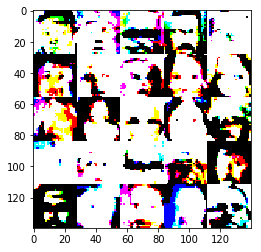

Epoch 5/5... Discriminator_Loss: 1.70174... Generator_Loss: 0.54646
Epoch 5/5... Discriminator_Loss: 1.17079... Generator_Loss: 1.78766
Epoch 5/5... Discriminator_Loss: 1.12772... Generator_Loss: 1.01222
Epoch 5/5... Discriminator_Loss: 1.35808... Generator_Loss: 1.73475
Epoch 5/5... Discriminator_Loss: 1.15714... Generator_Loss: 0.83401


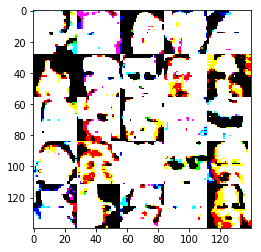

Epoch 5/5... Discriminator_Loss: 2.18350... Generator_Loss: 3.01047
Epoch 5/5... Discriminator_Loss: 1.12335... Generator_Loss: 0.94247
Epoch 5/5... Discriminator_Loss: 1.26212... Generator_Loss: 1.08245
Epoch 5/5... Discriminator_Loss: 1.11533... Generator_Loss: 1.13614
Epoch 5/5... Discriminator_Loss: 1.14867... Generator_Loss: 1.02729


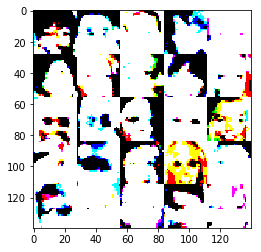

Epoch 5/5... Discriminator_Loss: 1.21307... Generator_Loss: 0.67714
Epoch 5/5... Discriminator_Loss: 1.06948... Generator_Loss: 0.74298
Epoch 5/5... Discriminator_Loss: 1.16546... Generator_Loss: 1.03696
Epoch 5/5... Discriminator_Loss: 1.22965... Generator_Loss: 1.25180
Epoch 5/5... Discriminator_Loss: 1.14097... Generator_Loss: 1.17600


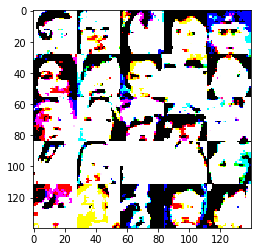

Epoch 5/5... Discriminator_Loss: 1.22361... Generator_Loss: 0.87653
Epoch 5/5... Discriminator_Loss: 1.18981... Generator_Loss: 0.82351
Epoch 5/5... Discriminator_Loss: 1.27278... Generator_Loss: 1.21392
Epoch 5/5... Discriminator_Loss: 1.31359... Generator_Loss: 0.73358
Epoch 5/5... Discriminator_Loss: 1.20377... Generator_Loss: 0.71455


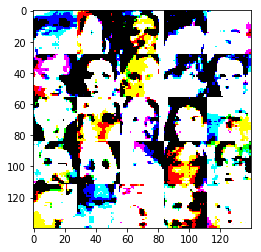

Epoch 5/5... Discriminator_Loss: 0.91518... Generator_Loss: 4.12002
Epoch 5/5... Discriminator_Loss: 0.41823... Generator_Loss: 2.78871
Epoch 5/5... Discriminator_Loss: 1.26579... Generator_Loss: 0.68152
Epoch 5/5... Discriminator_Loss: 1.57569... Generator_Loss: 0.41918
Epoch 5/5... Discriminator_Loss: 1.20003... Generator_Loss: 0.73428


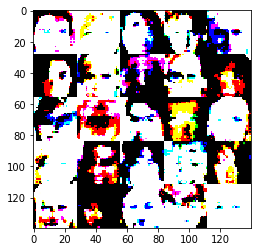

Epoch 5/5... Discriminator_Loss: 1.28489... Generator_Loss: 0.82173
Epoch 5/5... Discriminator_Loss: 1.07844... Generator_Loss: 0.97168
Epoch 5/5... Discriminator_Loss: 1.26228... Generator_Loss: 0.73796
Epoch 5/5... Discriminator_Loss: 1.16658... Generator_Loss: 0.79810
Epoch 5/5... Discriminator_Loss: 1.27881... Generator_Loss: 1.63851


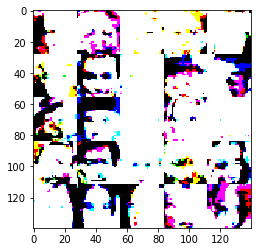

Epoch 5/5... Discriminator_Loss: 1.23477... Generator_Loss: 0.82906
Epoch 5/5... Discriminator_Loss: 1.25049... Generator_Loss: 0.89253
Epoch 5/5... Discriminator_Loss: 1.13590... Generator_Loss: 1.01177
Epoch 5/5... Discriminator_Loss: 1.22879... Generator_Loss: 0.78810
Epoch 5/5... Discriminator_Loss: 1.41647... Generator_Loss: 1.87310


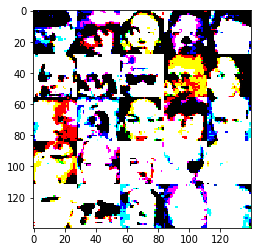

Epoch 5/5... Discriminator_Loss: 1.29669... Generator_Loss: 0.62755
Epoch 5/5... Discriminator_Loss: 1.29466... Generator_Loss: 0.72083
Epoch 5/5... Discriminator_Loss: 1.30949... Generator_Loss: 0.77554
Epoch 5/5... Discriminator_Loss: 1.78166... Generator_Loss: 0.35251
Epoch 5/5... Discriminator_Loss: 1.45354... Generator_Loss: 0.52057


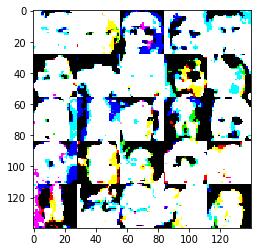

Epoch 5/5... Discriminator_Loss: 1.32002... Generator_Loss: 1.31490
Epoch 5/5... Discriminator_Loss: 1.23190... Generator_Loss: 0.86580
Epoch 5/5... Discriminator_Loss: 1.30395... Generator_Loss: 0.79251
Epoch 5/5... Discriminator_Loss: 1.22217... Generator_Loss: 0.95404
Epoch 5/5... Discriminator_Loss: 1.27429... Generator_Loss: 1.04398


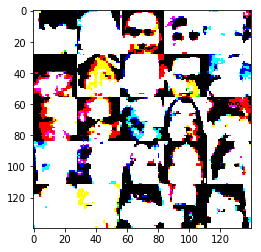

Epoch 5/5... Discriminator_Loss: 1.33963... Generator_Loss: 0.63520


In [13]:
batch_size = 100
z_dim = 100
learning_rate = 0.003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.